In [1]:

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
sensor_log,first_timestamp=load_sensor_log_file("../to_study/initial_chase_calib.txt")

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot as plt

gyro_t=[]
gyro=[]

#NN1 - outcome predictor
#inputs: motion magnitude, motion time, object position
#outputs: new object position

#NN2 - input predictor
#inputs: old object position, new object position
#outputs: motion magnitude, motion time

class VisualMotionDataset:
    def __init__(self):
        #objects to track
        self.objects_to_watch=["sports ball","stop sign","chair"]
        
        #defs of what goes where
        self.command_predictor_input_size=2
        self.command_predictor_output_size=3
        self.motion_predictor_input_size=4
        self.motion_predictor_output_size=1
        
        #scales of things
        self.position_scale=640

        #the accumulated data
        self.command_predictor_dataset_inputs=[]
        self.command_predictor_dataset_targets=[]
        self.motion_predictor_dataset_inputs=[]                
        self.motion_predictor_dataset_targets=[]                
        
        #last frame data 
        self.wait_after_motion_time=0.1
        self.last_motion_time=0
        self.gyro_stable_frame=False
        self.motor_stable_frame=False
        self.last_frame_tagged_objects=[]
        self.last_frame_motion_command=[]
        
    def produce_motion_predictor_dataset(self):
        return TensorDataset(torch.tensor(self.motion_predictor_dataset_inputs),torch.tensor(self.motion_predictor_dataset_targets))
            
                    
    def construct_tagged_object_info(self,tagged_objects):
        #return tag info for all objects for which only one is in list
        ret={}
        labels=[ x["label"] for x in tagged_objects ]        
        for obj in tagged_objects:
            label=obj["label"]
            if labels.count(label)==1:
                ret[label]=obj
        return ret
    
    def parse_message(self,message):
        if "position_sensor/gyro" in message:
            m=message["position_sensor/gyro"]
            gyro_z=message["position_sensor/gyro"][2]
            gyro_z_stdev=message["position_sensor/gyro_stdev"][2]            
            if abs(gyro_z)>0.05 or gyro_z_stdev>0.05:
                self.gyro_stable_frame=False                
            else:
                self.gyro_stable_frame=True
        if "drive/motors_active" in message:
            m=message["drive/motors_active"]
            if m[0]!=0 or m[1]!=0:
                self.motor_stable_frame=False
            else:
                self.motor_stable_frame=True
                
        if "motor_command" in message:
            m=message["motor_command"]
            if m["lr_throttle"][0] or m["lr_throttle"][1]!=0:
                self.last_motion_time=message["timestamp"]
                self.last_frame_motion_command=[ m["lr_throttle"][0],m["lr_throttle"][1],m["duration"]]
            
                
                
        if "tagged_objects" in message:
            if (not self.gyro_stable_frame) or (not self.motor_stable_frame) or (message["timestamp"]-self.last_motion_time<self.wait_after_motion_time):
                #print("unstable {} {} {}".format(self.gyro_stable_frame,self.motor_stable_frame,message["timestamp"]-self.last_motion_time))
                return #unstable frame, don't trust object tagger
            #print("stable {} {} {}".format(self.gyro_stable_frame,self.motor_stable_frame,message["timestamp"]-self.last_motion_time))
            tagged_objects=self.construct_tagged_object_info(message["tagged_objects"])
            #print("n tagged objects {}".format(len(tagged_objects)))
            for key in tagged_objects:
                if key not in self.last_frame_tagged_objects:
                    continue
                prev_startx=self.last_frame_tagged_objects[key]["startx"]
                prev_endx=self.last_frame_tagged_objects[key]["endx"]
                prev_x=0.5*(prev_startx+prev_endx)
                next_startx=tagged_objects[key]["startx"]
                next_endx=tagged_objects[key]["endx"]
                next_x=0.5*(next_startx+next_endx)
                self.motion_predictor_dataset_inputs.append( [prev_x/self.position_scale, *self.last_frame_motion_command ])
                self.motion_predictor_dataset_targets.append([ next_x/self.position_scale ])
                self.command_predictor_dataset_inputs.append( [prev_x/self.position_scale, next_x/self.position_scale])
                self.command_predictor_dataset_targets.append([ *self.last_frame_motion_command ] )
            self.last_frame_tagged_objects=tagged_objects           
            self.last_frame_motion_command=[0,0,0]
               
myset=VisualMotionDataset()
for message in sensor_log:
    myset.parse_message(message)
    #t=message["timestamp"]-first_timestamp
    
#print("motion-predictor size {}".format(len(myset.motion_predictor_dataset)))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

hidden_size=4
motion_predictor=nn.Sequential(nn.Linear(myset.motion_predictor_input_size,hidden_size),
                               nn.Tanh(),
                               nn.Linear(hidden_size,myset.motion_predictor_output_size))





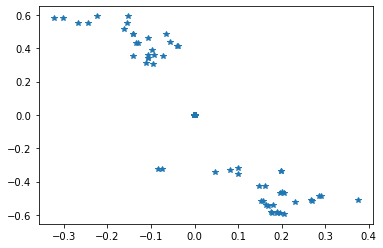

In [4]:
dataset=myset.produce_motion_predictor_dataset()
train_fraction=0.5
train_size=int(train_fraction*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=random_split(dataset,[train_size,test_size])

pows=[]
truths=[]
for x,y in test_dataset:
    pows.append( x[1].detach().numpy() )    
    truths.append( (y[0]-x[0]).detach().numpy())
    
fig, ax = plt.subplots()
ax.plot(truths,pows,'*')
plt.show()

In [5]:
from tqdm import tqdm
device = torch.device('cpu') 

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

def train_model_step(model,optimizer,inputs,targets):    
    loss_function = torch.nn.MSELoss()
    out=model( inputs) 
    loss=loss_function(out,targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_model_step(model,inputs,targets):    
    loss_function = torch.nn.MSELoss()
    out=model( inputs) 
    loss=loss_function(out,targets)   
    return loss.item()


def train_thing(model,train_dataloader,test_dataloader):
    # Loop over epochs
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    train_loss_log=[]
    test_loss_log=[]
    max_epochs=1000
    for epoch in tqdm(range(max_epochs)):
        # Training
        train_loss_sum=0
        counter=0
        for input_batch,target_batch in train_dataloader:
            #print("state batch shape {}".format(state_batch.shape))
            #print("command batch shape {}".format(command_batch.shape))
            #print("predict batch shape {}".format(result_batch.shape))
            # Transfer to GPU
            input_batch,target_batch=input_batch.to(device), target_batch.to(device)                                          
            train_loss_sum+=train_model_step(model,optimizer,input_batch,target_batch)
            counter+=1
        train_loss_log.append(train_loss_sum/counter)
    
        test_loss_sum=0
        counter=0
        with torch.set_grad_enabled(False):
            for input_batch, target_batch in test_dataloader:            
                # Transfer to GPU                
                input_batch, target_batch=input_batch.to(device), target_batch.to(device)                                                             
                test_loss_sum+=test_model_step(model,input_batch,target_batch)                
                counter+=1
        test_loss_log.append(test_loss_sum/counter)
    return train_loss_log,test_loss_log
    
train_loss_log,test_loss_log=train_thing(motion_predictor,train_dataloader,test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.30it/s]


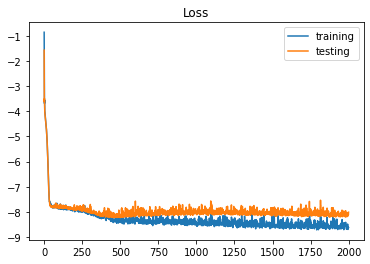

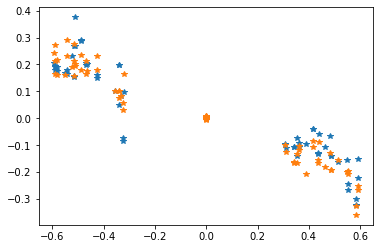

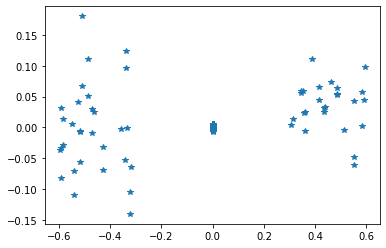

In [9]:

fig, ax = plt.subplots()
plt.title("Loss")
ax.plot(np.log(train_loss_log),label="training")
ax.plot(np.log(test_loss_log),label="testing")
plt.legend()
plt.show()

preds=[]
truths=[]
pows=[]
for x,y in test_dataset:
    yprime=(motion_predictor(torch.unsqueeze(x,0)))[0]
    pows.append( x[1].detach().numpy() )    
    preds.append( (yprime[0]-x[0]).detach().numpy())
    truths.append( (y[0]-x[0]).detach().numpy())
    
preds=np.array(preds)
truths=np.array(truths)
fig, ax = plt.subplots()
#ax.plot(truths)
#ax.plot(preds)
ax.plot(pows,truths,'*')
ax.plot(pows,preds,'*')
plt.show()

fig, ax = plt.subplots()
ax.plot(pows,truths-preds,'*')
plt.show()

In [ ]:
#on each action

# did my predictor predict the outcome well?  -> pred_err
# did my action inference infer the correct action -> act_err

